<a href="https://colab.research.google.com/github/ivanbperes/tcc-23780738-ivan-beretta-peres-unifran-2024/blob/main/tcc-23780738-ivan-beretta-peres-unifran-2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho de Conclusão de Curso
## Unifran - Universidade de Franca
<br>

**Discente:** Ivan Beretta Peres<br>
**RGM:** 23780738<br>

**Curso:** Bacharelado em Engenharia de Computação<br>
**Disciplina:** Projeto de Conclusão de Curso<br>
**Professor orientador:** Prof. Dr. Douglas Almendro<br>
**Ano:** 2024<br>

**Tema:** Visão Computacional aplicada ao diagnóstico de pneumonia em radiografias de tórax

## Importando bibliotecas e configurações iniciais

In [ ]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

## Carregando o banco de dados

In [ ]:
imagens_treino = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec")
tabela_treino = tf.data.TFRecordDataset("gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec")

ds = tf.data.Dataset.zip((imagens_treino, tabela_treino))

In [ ]:
COUNTAGEM_NORMAL = 0
for filename in tabela_treino:
    if "NORMAL" in filename.numpy().decode("utf-8"):
        COUNTAGEM_NORMAL += 1
print("Contagem de imagens normais na base de teste: " + str(COUNTAGEM_NORMAL))

COUNTAGEM_PNEUMONIA = 0
for filename in tabela_treino:
    if "PNEUMONIA" in filename.numpy().decode("utf-8"):
        COUNTAGEM_PNEUMONIA += 1
print("Contagem de imagens com pneumonia na base de teste: " + str(COUNTAGEM_PNEUMONIA))

Contagem de imagens normais na base de teste: 1349
Contagem de imagens com pneumonia na base de teste: 3883


In [ ]:
def processar_imagem_e_obter_rotulo(imagem_comprimida, caminho_arquivo):
    partes_caminho = tf.strings.split(caminho_arquivo, "/")
    rotulo = 1 if partes_caminho[-2] == "PNEUMONIA" else 0

    imagem = tf.image.decode_jpeg(imagem_comprimida, channels=3)
    imagem = tf.image.resize(imagem, IMAGE_SIZE)

    return imagem, rotulo

ds = ds.map(processar_imagem_e_obter_rotulo, num_parallel_calls=AUTOTUNE)

In [ ]:
ds = ds.shuffle(10000)
ds_treino = ds.take(4200)
ds_validacao = ds.skip(4200)

In [ ]:
imagens_teste = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
tabela_teste = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
ds_teste = tf.data.Dataset.zip((imagens_teste, tabela_teste))

ds_teste = ds_teste.map(processar_imagem_e_obter_rotulo, num_parallel_calls=AUTOTUNE)

contagem_imagens = 0
for _ in ds_teste:
    contagem_imagens += 1

print(f"Número de imagens no dataset de teste: {contagem_imagens}")

ds_teste = ds_teste.batch(BATCH_SIZE)

Número de imagens no dataset de teste: 624


## Visualiando o dataset e aplicando Data Augmentation

In [ ]:
def preparar_para_treino(ds, cache=True):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.map(lambda image, label: (tf.image.random_flip_left_right(image), label), num_parallel_calls=AUTOTUNE)
    ds = ds.map(lambda image, label: (tf.image.random_brightness(image, max_delta=0.2), label), num_parallel_calls=AUTOTUNE)

    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [ ]:
ds_treino = preparar_para_treino(ds_treino)
ds_validacao = preparar_para_treino(ds_validacao)

lote_imagens, lote_etiqueta = next(iter(ds_treino))

In [ ]:
def lote_exibir(lote_imagens, lote_etiqueta):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(lote_imagens[n] / 255)
        if lote_etiqueta[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

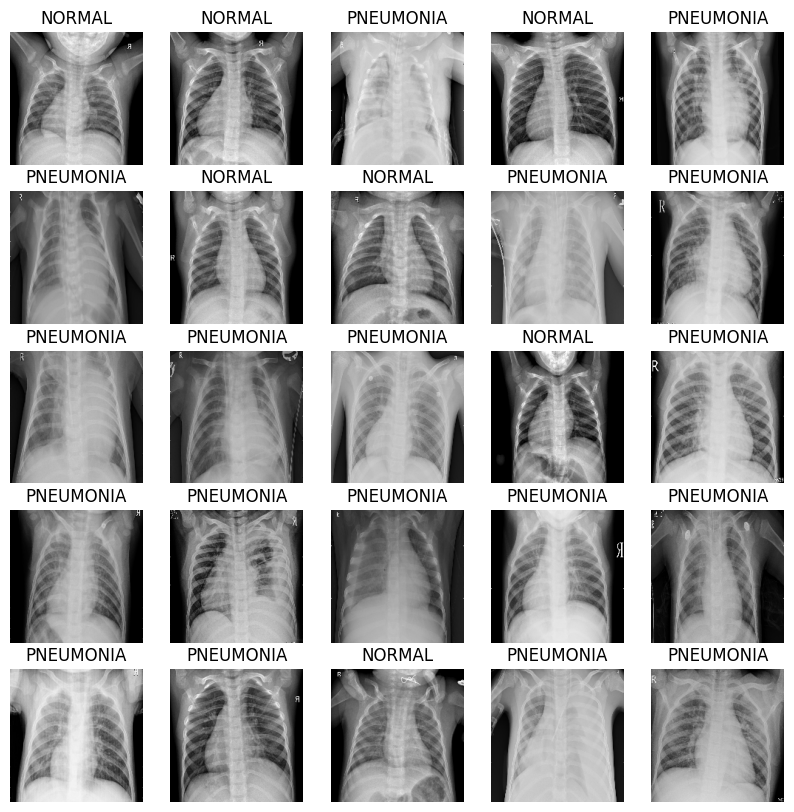

In [ ]:
lote_exibir(lote_imagens.numpy(), lote_etiqueta.numpy())

## Construindo o modelo

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers


def bloco_convolucional(filters, entradas):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(entradas)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    saidas = layers.MaxPool2D()(x)

    return saidas


def bloco_denso(units, dropout_rate, entradas):
    x = layers.Dense(units, activation="relu")(entradas)
    x = layers.BatchNormalization()(x)
    saidas = layers.Dropout(dropout_rate)(x)

    return saidas

In [ ]:
def construir_modelo():
    entradas = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(entradas)

    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)

    x = layers.MaxPool2D()(x)

    x = bloco_convolucional(32, x)
    x = bloco_convolucional(64, x)
    x = bloco_convolucional(128, x)
    x = layers.Dropout(0.2)(x)

    x = bloco_convolucional(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)

    x = bloco_denso(512, 0.7, x)
    x = bloco_denso(128, 0.5, x)
    x = bloco_denso(64, 0.3, x)

    saidas = layers.Dense(1, activation="sigmoid")(x)

    modelo = keras.Model(inputs=entradas, outputs=saidas)

    return modelo

In [ ]:
vies_inicial = np.log([COUNTAGEM_PNEUMONIA / COUNTAGEM_NORMAL])
print("Viés inicial: {:.5f}".format(vies_inicial[0]))

CONTAGEM_IMAGENS_TREINO = COUNTAGEM_NORMAL + COUNTAGEM_PNEUMONIA
peso_para_0 = (1 / COUNTAGEM_NORMAL) * (CONTAGEM_IMAGENS_TREINO) / 2.0
peso_para_1 = (1 / COUNTAGEM_PNEUMONIA) * (CONTAGEM_IMAGENS_TREINO) / 2.0

class_weight = {0: peso_para_0, 1: peso_para_1}

print("Peso para classe 0: {:.2f}".format(peso_para_0))
print("Peso para classe 1: {:.2f}".format(peso_para_1))

Viés inicial: 1.05724
Peso para classe 0: 1.94
Peso para classe 1: 0.67


## Treinando o modelo

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

parada_antecipada_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

In [ ]:
taxa_aprendizado_inicial = 0.015
taxa_aprendizado_agendamento = keras.optimizers.schedules.ExponentialDecay(
    taxa_aprendizado_inicial, decay_steps=100000, decay_rate=0.96, staircase=True
)

In [ ]:
modelo = construir_modelo()

METRICAS = [
    keras.metrics.BinaryAccuracy(),
    keras.metrics.Precision(name="precision"),
    keras.metrics.Recall(name="recall"),
]

modelo.compile(
    optimizer=keras.optimizers.Adam(learning_rate=taxa_aprendizado_agendamento),
    loss="binary_crossentropy",
    metrics=METRICAS,
)

history = modelo.fit(
    ds_treino,
    epochs=50,
    validation_data=ds_validacao,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, parada_antecipada_cb],
)

Epoch 1/50
168/168 [==============================] - 56s 291ms/step - loss: 0.4894 - binary_accuracy: 0.7660 - precision: 0.9139 - recall: 0.7581 - val_loss: 0.6586 - val_binary_accuracy: 0.6667 - val_precision: 0.9072 - val_recall: 0.6131
Epoch 2/50
168/168 [==============================] - 44s 261ms/step - loss: 0.2978 - binary_accuracy: 0.8800 - precision: 0.9586 - recall: 0.8773 - val_loss: 0.5417 - val_binary_accuracy: 0.8682 - val_precision: 0.9591 - val_recall: 0.8588
Epoch 3/50
168/168 [==============================] - 43s 256ms/step - loss: 0.2316 - binary_accuracy: 0.9133 - precision: 0.9686 - recall: 0.9136 - val_loss: 1.0248 - val_binary_accuracy: 0.7762 - val_precision: 0.7702 - val_recall: 0.9948
Epoch 4/50
168/168 [==============================] - 41s 245ms/step - loss: 0.2343 - binary_accuracy: 0.9088 - precision: 0.9681 - recall: 0.9079 - val_loss: 0.6383 - val_binary_accuracy: 0.8081 - val_precision: 0.9930 - val_recall: 0.7464
Epoch 5/50
168/168 [================

## Visualização da performance do modelo

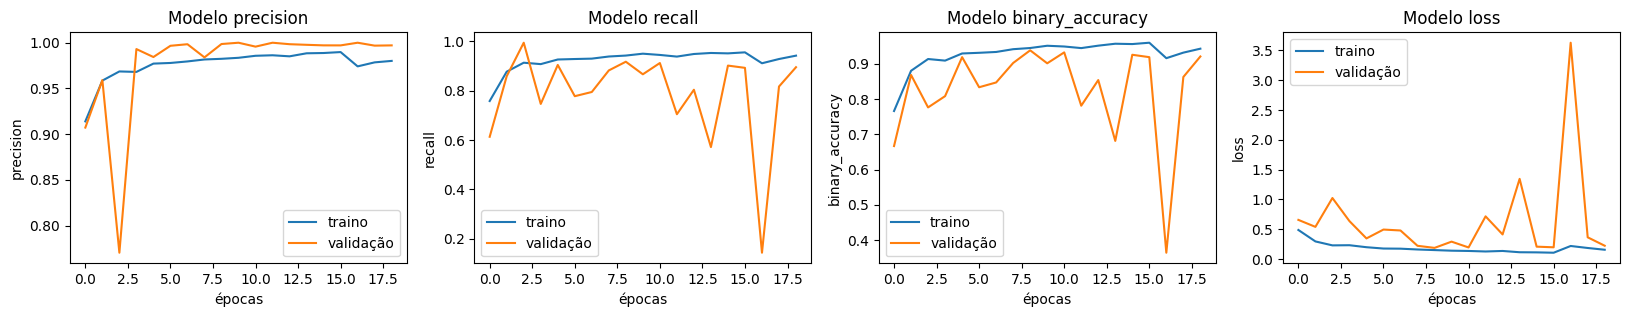

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Modelo {}".format(met))
    ax[i].set_xlabel("épocas")
    ax[i].set_ylabel(met)
    ax[i].legend(["traino", "validação"])

## Resultados obtidos

In [ ]:
modelo.evaluate(ds_teste, return_dict=True)

25/25 [==============================] - 1s 37ms/step - loss: 0.5924 - binary_accuracy: 0.8317 - precision: 0.8132 - recall: 0.9487


{'loss': 0.5923652648925781,
 'binary_accuracy': 0.8317307829856873,
 'precision': 0.8131868243217468,
 'recall': 0.9487179517745972}

25/25 [==============================] - 2s 38ms/step
F2 Score: 0.9181141439205955
Matriz de confusão:
[[149  85]
 [ 20 370]]


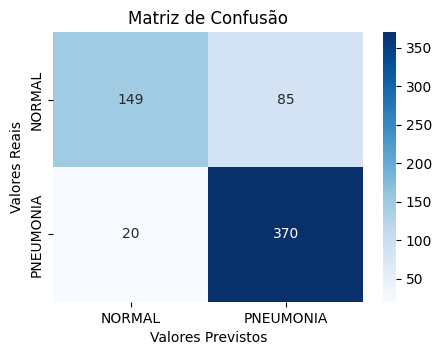

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, fbeta_score

valores_previstos = modelo.predict(ds_teste)
valores_previstos = (valores_previstos > 0.5).astype(int)

valores_reais = []
for _, etiqueta in ds_teste:
    valores_reais.extend(etiqueta.numpy())

valores_reais = np.array(valores_reais)

f2 = fbeta_score(valores_reais, valores_previstos, beta=2)
print(f"F2 Score: {f2}")

cm = confusion_matrix(valores_reais, valores_previstos)
print(f"Matriz de confusão:\n{cm}")

cm = confusion_matrix(valores_reais, valores_previstos)

plt.figure(figsize=(5, 3.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.xlabel("Valores Previstos")
plt.ylabel("Valores Reais")
plt.title("Matriz de Confusão")
plt.show()